In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import bert
import tensorflow_hub as hub
from transformers import BertTokenizer
from transformers import *
import pandas as pd

In [ ]:
def read_from_csv(mode='娛樂'):
    return pd.read_csv('/content/drive/MyDrive/Colab Notebooks/%s.csv'%(mode), names=['title', 'titleLink', 'content', 'label'], header=0)
#讀取資料集，並合併
raw_news = pd.concat([read_from_csv('娛樂'),read_from_csv('全球'),read_from_csv('要聞'),read_from_csv('運動'),read_from_csv('房產'),read_from_csv('健康'),read_from_csv('財經')
,read_from_csv('新奇'),read_from_csv('地方')],axis=0,ignore_index=True)
 
#打散資料集
raw_news=raw_news.sample(frac=1)
#排除空值
empty_title = ((raw_news['content'].isnull()) \
               | (raw_news['title'].isnull()) \
               | (raw_news['content'] == '') \
               | (raw_news['title'] == ''))
 
 
raw_news = raw_news[~empty_title]
raw_news['title_and_content'] = raw_news['title']+' '+raw_news['content']
raw_news = raw_news[['title_and_content','label']]
raw_news.label = raw_news.label.map({'娛樂':0,'全球':1,'要聞':2,'運動':3,'房產':4,'健康':5,'財經':6,'新奇':7,'地方':8})
raw_news

,title_and_content,label
34718,房市 逾2千萬接手少 高雄美術館豪宅降價賣 房價高漲 小宅轉夯 連高雄近期也有許多低總價的小...,4
69470,永和塌陷案提前一天搶通 6戶居民昨晚返家 上週新北永和發生的建築工地損鄰案 在施工團隊的搶救...,8
46277,頂新攜任中傑拜會中華職棒 味全龍復出進度加速 味全龍重出江湖的進度又往前邁進了 頂新集團發言...,6
6498,小鬼黃鴻升留給地球最後一首歌 扛得住 MV首播 小鬼 黃鴻升 生前與好友柯有倫 竇智孔合唱的...,0
30913,ABL 我希望有天我可以回來 阿提諾難忘台灣球迷 寶島夢想家前中鋒 目前效力馬來西亞吉隆坡猛...,3
...,...,...
47590,台幣周升逾2角 美元高檔震盪 日圓回落 後勢表現看這 美中貿易爭端露曙光 非美國貨幣大幅反彈...,6
73257,中捷小綠綠募資出包 議員批 把購買民眾當 盤子 迎接台中市捷運通車 台中捷運公司在群眾募資網...,8
14277,日本瘋傳 冷氣省電奇招 製造商一看急籲 恐得不償失 今年夏天台灣格外炎熱 連鄰近的日本也曾多...,1
10402,NBA 全明星賽照辦 威少心情差 反正我不會入選 聯盟人氣球星湖人一哥 詹皇 LeBron ...,1


In [ ]:
# 80% trains , 10% val , 00% test
 
df_train = raw_news[0:int(len(raw_news)*0.6)]
df_val = raw_news[int(len(raw_news)*0.6):int(len(raw_news)*0.7)]
df_test = raw_news[int(len(raw_news)*0.7):]
 
print('平均長度:', raw_news.title_and_content.str.len().mean())
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

平均長度: 689.4542959458399
(45908, 2)
(7651, 2)
(22955, 2)


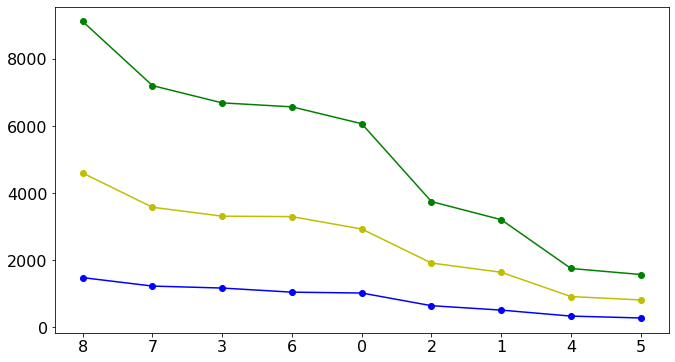

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import FontProperties
 
plt.figure(figsize=(11,6))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
 
df = df_train.label.value_counts().reset_index()
df.columns = ['label', 'count']
plt.plot(df['label'].astype(str),df['count'], 'go-')
 
df = df_val.label.value_counts().reset_index()
df.columns = ['label', 'count']
plt.plot(df['label'].astype(str),df['count'], 'bo-')
 
df = df_test.label.value_counts().reset_index()
df.columns = ['label', 'count']
plt.plot(df['label'].astype(str),df['count'],'yo-')

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
batch_size= 6 #http://fancyerii.github.io/2019/03/09/bert-codes/#%E5%AE%89%E8%A3%85
max_length=280
def convert_example_to_feature(review):
    return tokenizer.encode_plus(review,
                    add_special_tokens = True, # add [CLS], [SEP]
                    max_length = max_length, # max length of the text that can go to BERT
                    pad_to_max_length = True, # add [PAD] tokens
                    return_attention_mask = True, # add attention mask to not focus on pad tokens
                    )
 
# map to the expected input to TFBertForSequenceClassification, see here 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label
 
def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    input_ids_list2 = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
 
    for index, row in ds.iterrows():
        review = row["title_and_content"]
        label = row["label"]
        
        bert_input = convert_example_to_feature(review)
 
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
        
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:
ds_train_encoded = encode_examples(df_train).batch(batch_size)
ds_val_encoded = encode_examples(df_val).batch(batch_size)
ds_test_encoded = encode_examples(df_test).batch(batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from transformers import TFBertForSequenceClassification
                    
import tensorflow as tf
 
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 1e-5
# we will do just 1 epoch for illustration, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 6
 
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=9)
 
# optimizer Adam recommended
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-08, clipnorm=1)
 
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
# fit model
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_val_encoded)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

In [ ]:
# evaluate test set
from sklearn.metrics import recall_score,precision_score
 
evaluate={'name':['Accuracy','recall','precision'],'score':[model.evaluate(ds_test_encoded)[1],
                               recall_score(df_test.label,np.argmax(model.predict(ds_test_encoded)[0],axis=1), average=None)[1],
                               precision_score(df_test.label,np.argmax(model.predict(ds_test_encoded)[0],axis=1), average=None)[1]]}
evaluate

3826/3826 [==============================] - 489s 128ms/step - loss: 0.4865 - accuracy: 0.9041


{'name': ['Accuracy', 'recall', 'precision'],
 'score': [0.9041167497634888, 0.8261933904528764, 0.8323057953144266]}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


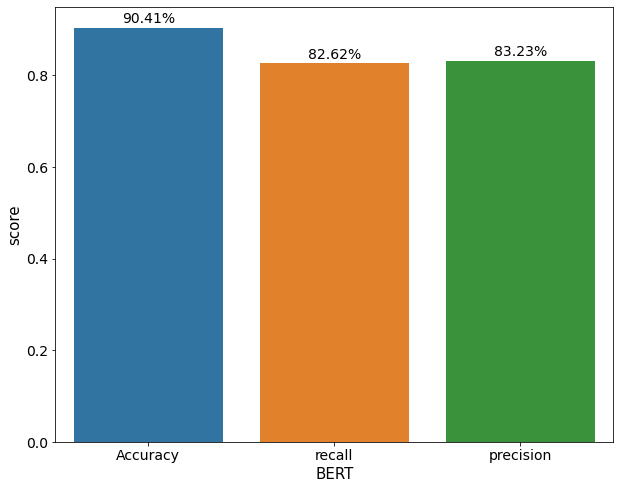

In [ ]:
plt.figure(figsize=(10,8))
 
ax=sns.barplot('name','score',data=pd.DataFrame(evaluate),linewidth=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('BERT',fontsize=15)
plt.ylabel('score',fontsize=15)
for p in ax.patches:
 height = p.get_height()
 ax.text(p.get_x()+p.get_width()/2.,#位置
 height+0.01,
 '{:1.2f}%'.format(height*100),
 ha="center", size=14)
plt.show()

Text(0.5, 142.31999999999996, 'Predicted label')

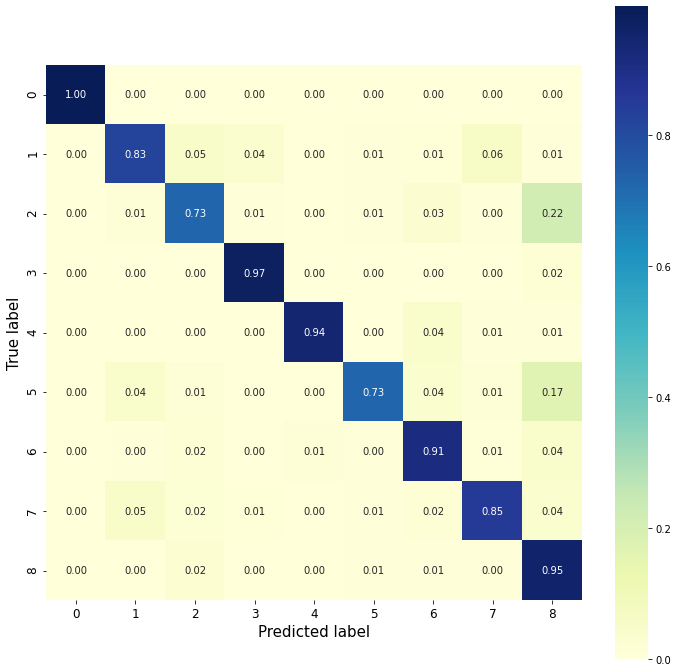

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
 
plt.figure(figsize=(12,12))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
pred=model.predict(ds_test_encoded)
C2= confusion_matrix(df_test.label.to_numpy(), np.argmax(pred[0], axis=1), labels=[i for i in range(9)])
C2 = C2.astype('float') / C2.sum(axis=1)[:, np.newaxis]
sns.heatmap(C2,annot=True,fmt=".2f", square=True, cmap='YlGnBu')
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)

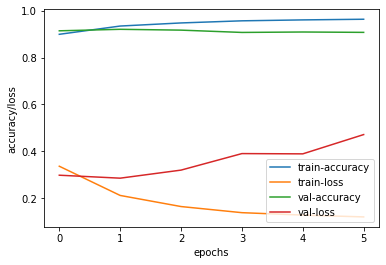

In [ ]:
import os
plt.plot(bert_history.history['accuracy'],label='train-accuracy')
plt.plot(bert_history.history['loss'],label='train-loss')
plt.plot(bert_history.history['val_accuracy'],label='val-accuracy')
plt.plot(bert_history.history['val_loss'],label='val-loss')
 
plt.ylabel('accuracy/loss')
plt.xlabel('epochs')
plt.legend(loc='lower right')

In [ ]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/bert_new.h5')

In [ ]:
!pip install bert-for-tf2
!pip install transformers

     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=22dcb531de348674043b850680f93f5e7e118394ca2fdb38b23c0729eeeee647
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=456dc41191ba64f7d7cd9d37de66f6392e923f9b63a9ce7f82ff8490c8ccc856
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=de6d018e9dcffb6304df66d71b3f5c9364cfc5d3fd0ed203a7da4cca4b0c245f
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.9MB 19.2MB/s 
     |███████████████████████████